<a href="https://colab.research.google.com/github/sagarstormborn/star_gan_final_year/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn

class con_batch_glu(nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size, stride, padding, dilation=1, groups=1, bias=False, padding_mode='zeros'):
    super(con_batch_glu,self).__init__()
    self.architecture=nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups,bias, padding_mode),
        nn.BatchNorm2d(num_features=out_channels,affine=True, track_running_stats=True),
    )
  
  def forward(self,x):
    x=self.architecture(x)
    x=nn.functional.glu(x,dim=1)
    return x


class Discriminator(nn.Module):

  def __init__(self): 
    super(Discriminator,self).__init__()
    self.para=[[32,(3,9),(1,1),(1, 4)],[32,(3,8),(1,2),(1, 3)],[32,(3,8),(1,2),(1, 3)],[32,(3,6),(1,2),(1, 2)]]

    in_channels=5
    i=0 #layer 1
    self.layer1=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +4
    i+=1
    self.layer2=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +4
    i+=1
    self.layer3=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +4
    i+=1
    self.layer4=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 


    self.layer_con=nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=(36,5), stride=(36,1), padding=(1,2))
    self.pool=nn.AvgPool2d(kernel_size=(1,64))
    

  def forward(self,x,c):
    c=c.view(c.shape[0],1,c.shape[1],c.shape[2]) # shape (nx1x4x4)

    c1=c.repeat(1,4,9,128) #shape [n , 4, 36, 512]
    x=torch.cat([x, c1], dim=1)
    x=self.layer1(x)

    c1=c.repeat(1,4,9,128) #shape [n , 4, 36, 512]
    x=torch.cat([x, c1], dim=1)
    x=self.layer2(x)

    c1=c.repeat(1,4,9,64) #shape [n , 4, 36, 256]
    x=torch.cat([x, c1], dim=1)
    x=self.layer3(x)

    c1=c.repeat(1,4,9,32) #shape [n , 4, 36, 32]
    x=torch.cat([x, c1], dim=1)
    x=self.layer4(x)

    x=self.layer_con(x)

    x=torch.sigmoid(x)
    x=self.pool(x)
    return x



class Domain(nn.Module):
  def __init__(self):
    super(Domain,self).__init__()
    self.para=[[8,(4,4),(2,2),(5, 1)],[16,(4,4),(2,2),(1,1)],[32,(4,4),(1,2),(0,1)],[16,(3,4),(1,2),(1,1)]]

    layers=[]
    in_channels=1
    for i in range(len(self.para)):
      layers.append(con_batch_glu(in_channels,*self.para[i]))
      in_channels=self.para[i][0]//2

    self.architecture=nn.Sequential(*layers)
    self.architecture.add_module("conv",nn.Conv2d(in_channels, out_channels=4, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1) ))
    self.architecture.add_module("softmax", nn.Softmax(dim=-1))
    self.architecture.add_module("pooling",nn.AvgPool2d((1, 16)) )

  def forward(self,x):
    x=x[:,:,0:8,:]
    x=self.architecture(x)
    return x



class decon_batch_glu(nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size, stride, padding, output_padding=0, groups=1, bias=False, dilation=1, padding_mode='zeros'):
    super(decon_batch_glu,self).__init__()
    self.architecture=nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride,padding, output_padding, groups, bias, dilation, padding_mode),
        nn.BatchNorm2d(num_features=out_channels,affine=True, track_running_stats=True),
    )
  
  def forward(self,x):
    x=self.architecture(x)
    x=nn.functional.glu(x,dim=1)
    return x


class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.para=[[32,(3,9),1,(1, 4)],[64,(4,8),(2,2),(1, 3)],[128,(4,8),(2,2),(1,3)],[64,(3,5),(1,1),(1,2)],[10,(9,5),(9,1),(1,2)]]

    layers=[]
    in_channels=1
    for i in range(len(self.para)):
      layers.append(con_batch_glu(in_channels,*self.para[i]))
      in_channels=self.para[i][0]//2

    self.para_1=[[64,(9,5),(9,1),(0, 2)],[128,(3,5),1,(1, 2)],[64,(4,8),(2,2),(1, 3)],[32,(4,8),(2,2),(1, 3)]]

    i=0 #layer 1
    in_channels+=4
    self.layer1=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +4
    i+=1

    self.layer2=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +4
    i+=1

    self.layer3=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +4
    i+=1

    self.layer4=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +4
    i+=1
    
    self.architecture=nn.Sequential(*layers)
    
    self.decon=nn.ConvTranspose2d(in_channels, out_channels=1, kernel_size=(3, 9), stride=(1, 1), padding=(1,4) )

    
  def forward(self,x,c):
    x=self.architecture(x)
    c=c.view(c.shape[0],c.shape[1],1,c.shape[2]) # shape (nx1x4x4)

    c1=c.repeat(1,1,1,32) #shape [n , 1, 1,128]
    x=torch.cat([x, c1], dim=1)
    x=self.layer1(x)

    c1=c.repeat(1,1,9,32) #shape [n , 1, 9,128]
    x=torch.cat([x, c1], dim=1)
    x=self.layer2(x)

    c1=c.repeat(1,1,9,32) #shape [n , 1, 9,128]
    x=torch.cat([x, c1], dim=1)
    x=self.layer3(x)

    c1=c.repeat(1,1,18,64) #shape [n , 1,18,256]
    x=torch.cat([x, c1], dim=1)
    x=self.layer4(x)

    c1=c.repeat(1,1,36,128) #shape [n ,1,36,512]
    x=torch.cat([x, c1], dim=1)

    x=self.decon(x)

    return x

In [2]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

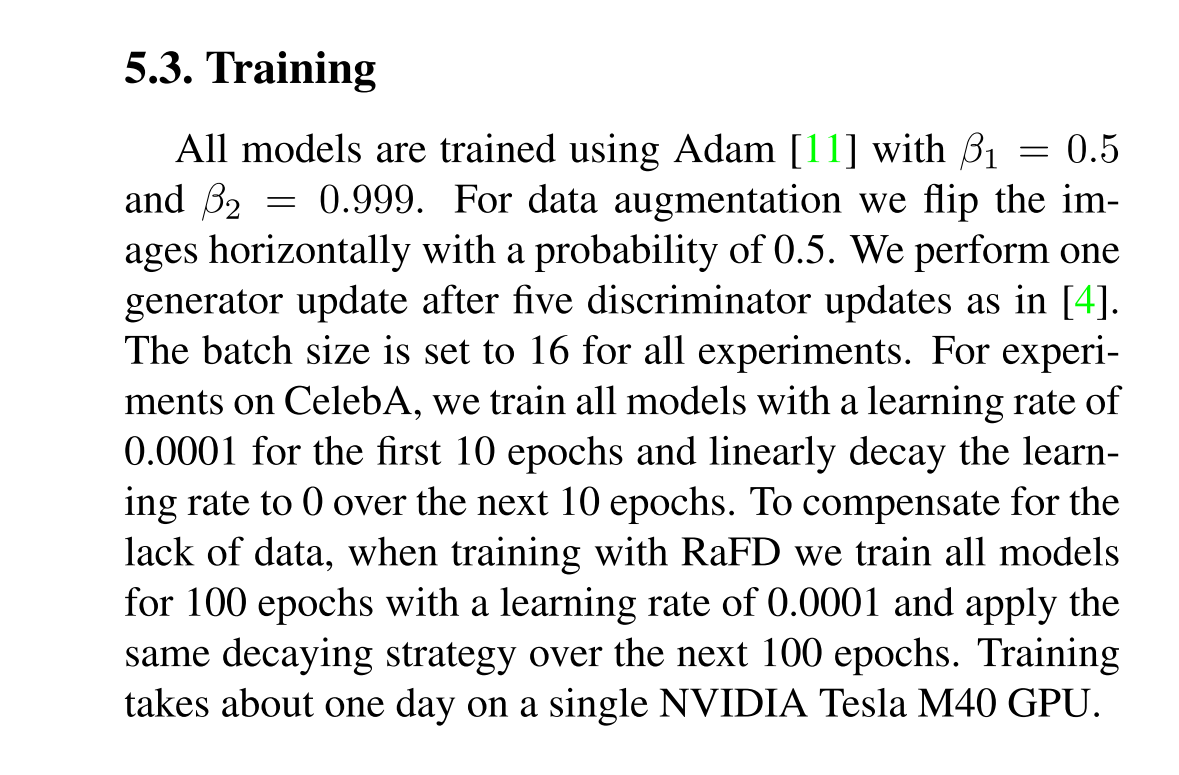

no hyperperameter stargan vc details we given so used from the orignal stargan model 


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = Generator().to(device)
disc = Discriminator().to(device)
dom = Domain().to(device)

initialize_weights(gen)
initialize_weights(disc)
initialize_weights(dom)


criterion_BCE = nn.BCELoss() # for discriminator
criterion_CEL=nn.BCELoss()#WithLogitsLoss #for domain_class
# criterion_MSE=nn.MSELoss()      # not used 
criterion_MABS=nn.L1Loss()      # for identity

opt_gen = torch.optim.Adam(gen.parameters(), 0.0001, [0.5,0.999])
opt_disc = torch.optim.Adam(disc.parameters(),0.0001, [0.5,0.999])
opt_dom = torch.optim.Adam(dom.parameters(), 0.0001, [0.5,0.999])


In [4]:
from torch.utils.data import Dataset,DataLoader
from glob import glob
import numpy as np
import multiprocessing


class audio_data(Dataset):
  def __init__(self,path="/content/drive/MyDrive/PREPROCESS_DATA/final_data/"):
    self.paths=glob(path+"*")
    self.total_length=len(self.paths)

  def __len__(self):
    return self.total_length

  def __getitem__(self,idx):
    data=np.load(self.paths[idx])
    mcc_features_s,mcc_features_t,c=data["mcc_features_s"],data["mcc_features_t"],data["c"]
    mcc_features_s=torch.Tensor(mcc_features_s)
    mcc_features_t=torch.Tensor(mcc_features_t)
    mcc_features_s,mcc_features_t=torch.transpose(mcc_features_s,0,1),torch.transpose(mcc_features_t,0,1)
    mcc_features_s=mcc_features_s.view(1,36,-1)
    mcc_features_t=mcc_features_t.view(1,36,-1)
    
    c=torch.Tensor(c)
    c_t=torch.transpose(c,0,1)[(c == 1).nonzero(as_tuple=True)[1]].view(-1)  # get tensor like tensor([[0., 0., 1., 0.]], dtype=torch.float64)
    c_s=c[(c == 1).nonzero(as_tuple=True)[0]].view(-1) # get tensor like tensor([[0., 1, 0., 0.]], dtype=torch.

    return mcc_features_s,mcc_features_t,c,c_s,c_t

dataset=audio_data()


pool = multiprocessing.Pool() # for geting no of avai workers

dataloader=DataLoader(dataset, batch_size=128, shuffle=True,
          num_workers=pool._processes, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

In [63]:
# a,b,c,c_s,c_t=dataset[8]
# # gen(a.view(1,1,36,512).to(device),c.view(1,4,4).to(device))
# print(a.shape,b.shape,c.shape,c_s.shape,c_t.shape)
# print(c_t,c_s)

torch.Size([1, 36, 512]) torch.Size([1, 36, 512]) torch.Size([4, 4]) torch.Size([4]) torch.Size([4])
tensor([1., 0., 0., 0.]) tensor([0., 1., 0., 0.])


In [ ]:
from tqdm import tqdm

NUM_EPOCHS=200

for epoch in range(NUM_EPOCHS):
  # print(epoch)

  for ind,(mcc_features_s,mcc_features_t,c,c_s,c_t) in tqdm(enumerate(dataloader)):
    mcc_features_s=mcc_features_s.to(device)
    mcc_features_t=mcc_features_t.to(device)
    c=c.to(device)
    c_s=c_s.to(device)
    c_t=c_t.to(device)

    fake = gen(mcc_features_s,c)

    ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
    disc_real = disc(mcc_features_t,c).reshape(-1)
    loss_disc_real = criterion_BCE(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake.detach(),c).reshape(-1)
    loss_disc_fake = criterion_BCE(disc_fake, torch.zeros_like(disc_fake))
    loss_disc = (loss_disc_real + loss_disc_fake) # /2
    loss_disc_=loss_disc

    disc.zero_grad()
    loss_disc.backward()
    opt_disc.step()

    ### Train domain_class

    dom_real_t =dom(mcc_features_t).view(-1,4)
    # dom_real_s =dom(mcc_features_s,c_s).reshape(-1)
    # dom_fake_t  =dom(mcc_features_t,c_s).reshape(-1)
    dom_fake_s  =dom(fake.detach()).view(-1,4)

    # print(dom_real_t.shape,c_t.shape)

    loss_dom_real = criterion_CEL(dom_real_t, c_t)

    loss_dom_fake = criterion_CEL(dom_fake_s, c_s)
    loss_dom = (loss_dom_fake  + loss_dom_real ) # /2
    loss_dom_=loss_dom # for printing loss


    dom.zero_grad()
    loss_dom.backward()
    opt_dom.step()



    ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
    output_gen = disc(fake,c).reshape(-1)
    loss_disc= criterion_BCE(output_gen, torch.ones_like(output_gen))

    output_dom=dom(fake).view(-1,4)
    loss_dom= criterion_CEL(output_dom, c_t)

    output_iden=gen(mcc_features_s,torch.transpose(c,1,2))
    loss_identi=criterion_MABS(output_iden,mcc_features_s)

    output_cycle=gen(gen(mcc_features_s,c),torch.transpose(c,1,2))
    loss_cycle=criterion_MABS(output_cycle,mcc_features_s)

    loss_gen=(loss_disc+loss_dom+loss_identi+loss_cycle) # /4


    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    print(f"epoch: {epoch} ,gen_loss: {loss_gen} disc_loss: {loss_disc_}, dom_loss: {loss_dom_}")

1it [00:03,  3.07s/it]

epoch: 0 ,gen_loss: 2.6856703758239746 disc_loss: 1.386296272277832, dom_loss: 1.4831020832061768


2it [00:05,  2.76s/it]

epoch: 0 ,gen_loss: 2.692261219024658 disc_loss: 1.3862910270690918, dom_loss: 1.4831020832061768


3it [00:07,  2.54s/it]

epoch: 0 ,gen_loss: 2.6941888332366943 disc_loss: 1.386286735534668, dom_loss: 1.4831020832061768


4it [00:09,  2.39s/it]

epoch: 0 ,gen_loss: 2.698641300201416 disc_loss: 1.3862791061401367, dom_loss: 1.4831020832061768


5it [00:10,  2.08s/it]

epoch: 0 ,gen_loss: 2.6847171783447266 disc_loss: 1.3862688541412354, dom_loss: 1.4831022024154663



1it [00:02,  2.89s/it]

epoch: 1 ,gen_loss: 2.685814619064331 disc_loss: 1.3862590789794922, dom_loss: 1.4831020832061768


2it [00:04,  2.64s/it]

epoch: 1 ,gen_loss: 2.693619966506958 disc_loss: 1.3862448930740356, dom_loss: 1.4831020832061768


3it [00:06,  2.46s/it]

epoch: 1 ,gen_loss: 2.693514347076416 disc_loss: 1.3862284421920776, dom_loss: 1.4831020832061768


4it [00:09,  2.34s/it]

epoch: 1 ,gen_loss: 2.692805767059326 disc_loss: 1.3861982822418213, dom_loss: 1.4831020832061768


5it [00:10,  2.07s/it]

epoch: 1 ,gen_loss: 2.6797006130218506 disc_loss: 1.3861706256866455, dom_loss: 1.4831022024154663



1it [00:03,  3.02s/it]

epoch: 2 ,gen_loss: 2.6861610412597656 disc_loss: 1.386122226715088, dom_loss: 1.4831020832061768


2it [00:05,  2.73s/it]

epoch: 2 ,gen_loss: 2.6905112266540527 disc_loss: 1.3860619068145752, dom_loss: 1.4831020832061768


3it [00:07,  2.53s/it]

epoch: 2 ,gen_loss: 2.6809885501861572 disc_loss: 1.385953664779663, dom_loss: 1.4831020832061768


4it [00:09,  2.39s/it]

epoch: 2 ,gen_loss: 2.6947977542877197 disc_loss: 1.3858445882797241, dom_loss: 1.4831020832061768


5it [00:10,  2.10s/it]

epoch: 2 ,gen_loss: 2.688599109649658 disc_loss: 1.3856520652770996, dom_loss: 1.4831022024154663



1it [00:03,  3.08s/it]

epoch: 3 ,gen_loss: 2.6880691051483154 disc_loss: 1.3854072093963623, dom_loss: 1.4831020832061768


2it [00:05,  2.79s/it]

epoch: 3 ,gen_loss: 2.691375970840454 disc_loss: 1.3851318359375, dom_loss: 1.4831020832061768


3it [00:07,  2.58s/it]

epoch: 3 ,gen_loss: 2.685227870941162 disc_loss: 1.3845906257629395, dom_loss: 1.4831020832061768


4it [00:09,  2.43s/it]

epoch: 3 ,gen_loss: 2.685528039932251 disc_loss: 1.3840457201004028, dom_loss: 1.4831020832061768


5it [00:10,  2.13s/it]

epoch: 3 ,gen_loss: 2.682140350341797 disc_loss: 1.3833210468292236, dom_loss: 1.4831022024154663



1it [00:02,  2.94s/it]

epoch: 4 ,gen_loss: 2.687323570251465 disc_loss: 1.3820433616638184, dom_loss: 1.4831020832061768


2it [00:05,  2.69s/it]

epoch: 4 ,gen_loss: 2.682575225830078 disc_loss: 1.3806772232055664, dom_loss: 1.4831020832061768


3it [00:07,  2.51s/it]

epoch: 4 ,gen_loss: 2.685508966445923 disc_loss: 1.378556251525879, dom_loss: 1.4831020832061768


4it [00:09,  2.38s/it]

epoch: 4 ,gen_loss: 2.6919631958007812 disc_loss: 1.3759546279907227, dom_loss: 1.4831020832061768


5it [00:10,  2.10s/it]

epoch: 4 ,gen_loss: 2.6930794715881348 disc_loss: 1.3730504512786865, dom_loss: 1.4831022024154663



1it [00:02,  2.98s/it]

epoch: 5 ,gen_loss: 2.69167160987854 disc_loss: 1.3689227104187012, dom_loss: 1.4831020832061768


2it [00:05,  2.72s/it]

epoch: 5 ,gen_loss: 2.6919493675231934 disc_loss: 1.364607334136963, dom_loss: 1.4831020832061768


3it [00:07,  2.54s/it]

epoch: 5 ,gen_loss: 2.6956896781921387 disc_loss: 1.36091947555542, dom_loss: 1.4831020832061768


4it [00:09,  2.41s/it]

epoch: 5 ,gen_loss: 2.686434507369995 disc_loss: 1.3542263507843018, dom_loss: 1.4831020832061768


5it [00:10,  2.13s/it]

epoch: 5 ,gen_loss: 2.700043201446533 disc_loss: 1.347963571548462, dom_loss: 1.4831022024154663



1it [00:02,  2.98s/it]

epoch: 6 ,gen_loss: 2.703266143798828 disc_loss: 1.3409777879714966, dom_loss: 1.4831020832061768


2it [00:05,  2.72s/it]

epoch: 6 ,gen_loss: 2.696931838989258 disc_loss: 1.3391203880310059, dom_loss: 1.4831020832061768


3it [00:07,  2.55s/it]

epoch: 6 ,gen_loss: 2.7009201049804688 disc_loss: 1.326884150505066, dom_loss: 1.4831020832061768


4it [00:09,  2.42s/it]

epoch: 6 ,gen_loss: 2.7048447132110596 disc_loss: 1.319040060043335, dom_loss: 1.4831020832061768


5it [00:10,  2.14s/it]

epoch: 6 ,gen_loss: 2.711082696914673 disc_loss: 1.317643165588379, dom_loss: 1.4831022024154663



1it [00:02,  2.96s/it]

epoch: 7 ,gen_loss: 2.703129529953003 disc_loss: 1.3038748502731323, dom_loss: 1.4831020832061768


2it [00:05,  2.71s/it]

epoch: 7 ,gen_loss: 2.7160327434539795 disc_loss: 1.3000953197479248, dom_loss: 1.4831020832061768


3it [00:07,  2.54s/it]

epoch: 7 ,gen_loss: 2.7194314002990723 disc_loss: 1.2960965633392334, dom_loss: 1.4831020832061768


4it [00:09,  2.42s/it]

epoch: 7 ,gen_loss: 2.7286300659179688 disc_loss: 1.2842354774475098, dom_loss: 1.4831020832061768


5it [00:10,  2.14s/it]

epoch: 7 ,gen_loss: 2.722545862197876 disc_loss: 1.281989574432373, dom_loss: 1.4831022024154663



1it [00:03,  3.01s/it]

epoch: 8 ,gen_loss: 2.7322633266448975 disc_loss: 1.2684745788574219, dom_loss: 1.4831020832061768


2it [00:05,  2.75s/it]

epoch: 8 ,gen_loss: 2.7339651584625244 disc_loss: 1.2614749670028687, dom_loss: 1.4831020832061768


3it [00:07,  2.57s/it]

epoch: 8 ,gen_loss: 2.7407307624816895 disc_loss: 1.2558362483978271, dom_loss: 1.4831020832061768


4it [00:09,  2.44s/it]

epoch: 8 ,gen_loss: 2.7394702434539795 disc_loss: 1.2546241283416748, dom_loss: 1.4831020832061768


5it [00:10,  2.15s/it]

epoch: 8 ,gen_loss: 2.751732349395752 disc_loss: 1.263963222503662, dom_loss: 1.4831022024154663



1it [00:03,  3.15s/it]

epoch: 9 ,gen_loss: 2.7678234577178955 disc_loss: 1.2257521152496338, dom_loss: 1.4831020832061768


2it [00:05,  2.84s/it]

epoch: 9 ,gen_loss: 2.7544288635253906 disc_loss: 1.2343637943267822, dom_loss: 1.4831020832061768


3it [00:07,  2.63s/it]

epoch: 9 ,gen_loss: 2.749260425567627 disc_loss: 1.2407115697860718, dom_loss: 1.4831020832061768


4it [00:09,  2.48s/it]

epoch: 9 ,gen_loss: 2.765650987625122 disc_loss: 1.208492636680603, dom_loss: 1.4831020832061768


5it [00:10,  2.17s/it]

epoch: 9 ,gen_loss: 2.7710494995117188 disc_loss: 1.215327262878418, dom_loss: 1.4831022024154663



1it [00:02,  2.96s/it]

epoch: 10 ,gen_loss: 2.755741834640503 disc_loss: 1.2135636806488037, dom_loss: 1.4831020832061768


2it [00:05,  2.71s/it]

epoch: 10 ,gen_loss: 2.7830421924591064 disc_loss: 1.2276241779327393, dom_loss: 1.4831020832061768


3it [00:07,  2.53s/it]

epoch: 10 ,gen_loss: 2.7745044231414795 disc_loss: 1.195823311805725, dom_loss: 1.4831020832061768


4it [00:09,  2.41s/it]

epoch: 10 ,gen_loss: 2.800161361694336 disc_loss: 1.1826804876327515, dom_loss: 1.4831020832061768


5it [00:10,  2.12s/it]

epoch: 10 ,gen_loss: 2.79890775680542 disc_loss: 1.1702803373336792, dom_loss: 1.4831022024154663



1it [00:03,  3.13s/it]

epoch: 11 ,gen_loss: 2.7913894653320312 disc_loss: 1.1630487442016602, dom_loss: 1.4831020832061768


2it [00:05,  2.83s/it]

epoch: 11 ,gen_loss: 2.811211109161377 disc_loss: 1.1559460163116455, dom_loss: 1.4831020832061768


3it [00:07,  2.61s/it]

epoch: 11 ,gen_loss: 2.7999463081359863 disc_loss: 1.2093665599822998, dom_loss: 1.4831020832061768


4it [00:09,  2.46s/it]

epoch: 11 ,gen_loss: 2.8243114948272705 disc_loss: 1.1673465967178345, dom_loss: 1.4831020832061768


5it [00:10,  2.15s/it]

epoch: 11 ,gen_loss: 2.8192813396453857 disc_loss: 1.1331377029418945, dom_loss: 1.4831022024154663



1it [00:03,  3.10s/it]

epoch: 12 ,gen_loss: 2.826509952545166 disc_loss: 1.1468071937561035, dom_loss: 1.4831020832061768


2it [00:05,  2.80s/it]

epoch: 12 ,gen_loss: 2.820345878601074 disc_loss: 1.122021198272705, dom_loss: 1.4831020832061768


3it [00:07,  2.60s/it]

epoch: 12 ,gen_loss: 2.836486339569092 disc_loss: 1.1372272968292236, dom_loss: 1.4831020832061768


4it [00:09,  2.45s/it]

epoch: 12 ,gen_loss: 2.816864490509033 disc_loss: 1.1396307945251465, dom_loss: 1.4831020832061768


5it [00:10,  2.15s/it]

epoch: 12 ,gen_loss: 2.8285112380981445 disc_loss: 1.113823413848877, dom_loss: 1.4831022024154663



1it [00:02,  2.96s/it]

epoch: 13 ,gen_loss: 2.8344640731811523 disc_loss: 1.1431008577346802, dom_loss: 1.4831020832061768


2it [00:05,  2.70s/it]

epoch: 13 ,gen_loss: 2.8352601528167725 disc_loss: 1.1074178218841553, dom_loss: 1.4831020832061768


3it [00:07,  2.53s/it]

epoch: 13 ,gen_loss: 2.8407700061798096 disc_loss: 1.102787971496582, dom_loss: 1.4831020832061768


4it [00:09,  2.41s/it]

epoch: 13 ,gen_loss: 2.854306936264038 disc_loss: 1.1096792221069336, dom_loss: 1.4831020832061768


5it [00:10,  2.12s/it]

epoch: 13 ,gen_loss: 2.871918201446533 disc_loss: 1.0732399225234985, dom_loss: 1.4831022024154663



1it [00:02,  2.99s/it]

epoch: 14 ,gen_loss: 2.8626887798309326 disc_loss: 1.07789945602417, dom_loss: 1.4831020832061768


2it [00:05,  2.73s/it]

epoch: 14 ,gen_loss: 2.87661075592041 disc_loss: 1.085977554321289, dom_loss: 1.4831020832061768


3it [00:07,  2.55s/it]

epoch: 14 ,gen_loss: 2.8889994621276855 disc_loss: 1.0919110774993896, dom_loss: 1.4831020832061768


4it [00:09,  2.42s/it]

epoch: 14 ,gen_loss: 2.8542098999023438 disc_loss: 1.0949046611785889, dom_loss: 1.4831020832061768


5it [00:10,  2.14s/it]

epoch: 14 ,gen_loss: 2.873405694961548 disc_loss: 1.0772998332977295, dom_loss: 1.4831022024154663



1it [00:03,  3.13s/it]

epoch: 15 ,gen_loss: 2.87831974029541 disc_loss: 1.0667660236358643, dom_loss: 1.4831020832061768


2it [00:05,  2.82s/it]

epoch: 15 ,gen_loss: 2.8730597496032715 disc_loss: 1.0535869598388672, dom_loss: 1.4831020832061768


3it [00:07,  2.61s/it]

epoch: 15 ,gen_loss: 2.892035484313965 disc_loss: 1.0426892042160034, dom_loss: 1.4831020832061768


4it [00:09,  2.47s/it]

epoch: 15 ,gen_loss: 2.8974263668060303 disc_loss: 1.049870252609253, dom_loss: 1.4831020832061768


5it [00:10,  2.16s/it]

epoch: 15 ,gen_loss: 2.9144277572631836 disc_loss: 1.0186101198196411, dom_loss: 1.4831022024154663



1it [00:03,  3.15s/it]

epoch: 16 ,gen_loss: 2.913801908493042 disc_loss: 1.0109238624572754, dom_loss: 1.4831020832061768


2it [00:05,  2.84s/it]

epoch: 16 ,gen_loss: 2.885397434234619 disc_loss: 1.0394399166107178, dom_loss: 1.4831020832061768


3it [00:07,  2.63s/it]

epoch: 16 ,gen_loss: 2.9189937114715576 disc_loss: 1.0216349363327026, dom_loss: 1.4831020832061768


4it [00:09,  2.48s/it]

epoch: 16 ,gen_loss: 2.9281091690063477 disc_loss: 0.9985781908035278, dom_loss: 1.4831020832061768


5it [00:10,  2.17s/it]

epoch: 16 ,gen_loss: 2.9120664596557617 disc_loss: 1.0056723356246948, dom_loss: 1.4831022024154663



1it [00:02,  2.99s/it]

epoch: 17 ,gen_loss: 2.907053232192993 disc_loss: 0.9950844645500183, dom_loss: 1.4831020832061768


2it [00:05,  2.73s/it]

epoch: 17 ,gen_loss: 2.9301342964172363 disc_loss: 0.9929980039596558, dom_loss: 1.4831020832061768


3it [00:07,  2.55s/it]

epoch: 17 ,gen_loss: 2.938490152359009 disc_loss: 0.9854108691215515, dom_loss: 1.4831020832061768


4it [00:09,  2.42s/it]

epoch: 17 ,gen_loss: 2.936882257461548 disc_loss: 0.9848880767822266, dom_loss: 1.4831020832061768


5it [00:10,  2.14s/it]

epoch: 17 ,gen_loss: 2.913141965866089 disc_loss: 0.9962718486785889, dom_loss: 1.4831022024154663



1it [00:02,  2.97s/it]

epoch: 18 ,gen_loss: 2.9348857402801514 disc_loss: 0.984254002571106, dom_loss: 1.4831020832061768


2it [00:05,  2.72s/it]

epoch: 18 ,gen_loss: 2.9565834999084473 disc_loss: 0.9565496444702148, dom_loss: 1.4831020832061768


3it [00:07,  2.54s/it]

epoch: 18 ,gen_loss: 2.9260239601135254 disc_loss: 0.9834131002426147, dom_loss: 1.4831020832061768


4it [00:09,  2.42s/it]

epoch: 18 ,gen_loss: 2.9611899852752686 disc_loss: 0.9515508413314819, dom_loss: 1.4831020832061768


5it [00:10,  2.14s/it]

epoch: 18 ,gen_loss: 2.968740940093994 disc_loss: 0.9426282048225403, dom_loss: 1.4831022024154663



1it [00:03,  3.14s/it]

epoch: 19 ,gen_loss: 2.9519436359405518 disc_loss: 0.9472297430038452, dom_loss: 1.4831020832061768


2it [00:05,  2.84s/it]

epoch: 19 ,gen_loss: 2.929492950439453 disc_loss: 0.9641337394714355, dom_loss: 1.4831020832061768


3it [00:07,  2.62s/it]

epoch: 19 ,gen_loss: 2.98134708404541 disc_loss: 0.9381029009819031, dom_loss: 1.4831020832061768


4it [00:09,  2.48s/it]

epoch: 19 ,gen_loss: 2.9999642372131348 disc_loss: 0.9169908165931702, dom_loss: 1.4831020832061768


5it [00:10,  2.17s/it]

epoch: 19 ,gen_loss: 2.9801039695739746 disc_loss: 0.9231578707695007, dom_loss: 1.4831022024154663



1it [00:02,  2.97s/it]

epoch: 20 ,gen_loss: 2.9561359882354736 disc_loss: 0.9285066723823547, dom_loss: 1.4831020832061768


2it [00:05,  2.72s/it]

epoch: 20 ,gen_loss: 2.9924395084381104 disc_loss: 0.9112275838851929, dom_loss: 1.4831020832061768


3it [00:07,  2.54s/it]

epoch: 20 ,gen_loss: 2.973004102706909 disc_loss: 0.9290133714675903, dom_loss: 1.4831020832061768


4it [00:09,  2.42s/it]

epoch: 20 ,gen_loss: 2.9685287475585938 disc_loss: 0.9186382293701172, dom_loss: 1.4831020832061768


5it [00:10,  2.13s/it]

epoch: 20 ,gen_loss: 3.027373790740967 disc_loss: 0.8861271739006042, dom_loss: 1.4831022024154663



1it [00:02,  2.96s/it]

epoch: 21 ,gen_loss: 2.9937150478363037 disc_loss: 0.9150581359863281, dom_loss: 1.4831020832061768


2it [00:05,  2.71s/it]

epoch: 21 ,gen_loss: 2.968731641769409 disc_loss: 0.9238983392715454, dom_loss: 1.4831020832061768


3it [00:07,  2.54s/it]

epoch: 21 ,gen_loss: 3.028318405151367 disc_loss: 0.8940372467041016, dom_loss: 1.4831020832061768


4it [00:09,  2.41s/it]

epoch: 21 ,gen_loss: 3.0261971950531006 disc_loss: 0.876964807510376, dom_loss: 1.4831020832061768


5it [00:10,  2.13s/it]

epoch: 21 ,gen_loss: 2.9896798133850098 disc_loss: 0.8836583495140076, dom_loss: 1.4831022024154663



1it [00:02,  3.00s/it]

epoch: 22 ,gen_loss: 2.9916903972625732 disc_loss: 0.883508563041687, dom_loss: 1.4831020832061768
